# MAGIC Geminga DL3 analysis
Giovanni Ceribella
(ceribell@mpp.mpg.de)
05/08/2025

![Polar phaseogram](data/Geminga/polarnice.png)

# Introduction
In physics, **phase** is the real dimensionless argument, expressed as a fraction of cycles, that governs a periodic phenomenon. So, in a generic wave $e^{i\Phi(t)}$, the phase is $\Phi(t)$, here given a dependence on time. Phase is usually also expressed as an angle $\vartheta=2\pi\,\Phi$, such that $\Delta\Phi=1 \rightarrow \Delta\vartheta=2\pi\,\text{rad}$. The derivative of phase over time is the (instantaneous) frequency of the periodic phenomenon $\nu(t)=d\Phi/dt$, whereas the derivative of the corresponding angle $\vartheta$ is the pulsation $\omega(t)=d\vartheta/dt$. A rotating pulsar is a periodic phenomenon, and as such can be attributed a phase, corresponding to the number of turns it has done since an arbitrary, reference starting moment.

Phase at an instant $t$ can be broken up into an integer part $\lfloor\Phi(t)\rfloor$ and a fractional part $\varphi=\{\Phi\}=(\Phi\mod1)$. The integer part is just counting how many full turns the pulsar has done until that moment. The fractional part $\varphi$, which is often called simply "phase", relates instead to the angle the pulsar is presenting to the observer at that very moment $t$. Given the periodic nature of pulsar signals, the emission as a function of $\{\varphi\}$ is of great physical importance, because it conveys information on what part of the pulsar magnetosphere is responsible for what emission. Studying the instantaneous emission of a pulsar as a function of $\varphi$ is impossible, as very few $\gamma$-rays can be measured in the short time span of a single pulsar rotation (typically less than a second). Instead, data is collected for a much longer time interval, and a value $\varphi_i$ is then attributed to each event, based on a model of the pulsar rotation that is commonly called a *pulsar ephemeris*. The data can later be grouped using the values of $\varphi_i$ to get a measurement of the emission from different *phase regions* defined by sub-intervals $(\varphi_i,\varphi_f) \subseteq (0,1)$ corresponding to different parts of the magnetosphere. Generating and applying *ephemerides* for pulsars is beyond the scope of this notebook.

All the $\gamma$-ray pulsars detected by IACTs so far present a quiescent state during a phase interval $(\varphi_{i}^0, \varphi_{f}^0)$ that we call the "off region". That is to say, at every cycle of the pulsar, for a certain time the $\gamma$-ray source effectively turns off. This fact can be exploited to define the background estimator for the computation of spectra *as a region of phase*, rather than a function of space as in the various ways employed for the construction of background maps. This procedure has the advantage to guarantee an estimate from a background that is both quasi-simultaneous (down to the sub-second time span of a pulsar period) and from the very same region of the sky the source we want to measure is at. As a result, the background estimate uncertainty, among the largest contributors to the systematic uncertainties for regular IACTs analyses, is effectively removed. Thanks to this strategy the dim, low-energy pulsar emission can be soundly detected even in the presence of a background that is much larger than the signal itself ($SNR\sim1\%$), which would otherwise "drown" the signal.

In the following, we will see how to do a simple pulsed analysis using MAGIC DL3 files of the Geminga pulsar and gammapy. These DL3 files were further processed with a simple script to add an extra column to their FITS event table "PULSE_PHASE", which contains the value of $\varphi$ for every event. Much of this notebook is based upon the master thesis work of Yunhe Wang, which I refer to for further details.

# Phaseogram

A diagram of the number of recorded excess events versus the rotational phase $\varphi$ (variously called "lightcurve", "phasogram", "phaseogram", etc. by different people) bears information on the relative intensities of the emission from different parts of the magnetosphere even when not fully accounting for the instrument exposure. This is because the IRFs are independent on phase, which is the same as says that they don't vary on the sub-second scale of a single pulsar rotation. Unfortunately, `gammapy` does not have a method to build phaseograms, so we use astropy's fits module to read the fits files directly.

To produce a meaningful phaseogram, energy-dependent $\theta^2$ cuts should be applied to reduce the effect of the large cosmic ray background. Gammaness/Hadronness cuts are already applied when creating pointlike DL3 files, whereas the $\theta^2$ ones are incorporated into the definition of the IRFs. In order to plot a phaseogram and calculate the significance of the emission from a certain phase region, we have to collect events that satisfy both the gammaness and $\theta^2$ cut.

In [1]:
import glob

from   astropy.io    import fits
from   astropy.table import Table
from   astropy.coordinates import angular_separation
import astropy.units as u

We can set some global energy limits for the phaseogram but (REMEMBER!) since we are cutting event by event, these are necessarily **reconstructed** energies. There is no way to give a true energy to a single event, only to a statistical enseble of them. The limits here were determined by looking at the expected excess count rates versus reconstructed energy, folding a spectrum similar to the one of Geminga with the IRFs. No excess is expected below a reconstructed energy of 25 GeV (but the true energy could easily be half of it!) or beyond 100 GeV, so we limit the search to these energies. It is important not to play with these values to get the highest possible significance, as that would induce a systematic bias (trial factor).

In [2]:
emin = 25.0*u.GeV
emax = 100.0*u.GeV

We now read though the files one by one, retrieve the event lists, the energy-dependent radial cuts, and fill an array with the phases of the events that pass the cuts.

In [3]:
ifiles = glob.glob("data/Geminga/20*Geminga*.fits")
phases = []

for ifile in ifiles:
    hdulist = fits.open(ifile)
    #Reading the position of Geminga for the theta cut
    src_ra  = hdulist['EVENTS'].header['RA_OBJ']*u.deg
    src_dec = hdulist['EVENTS'].header['DEC_OBJ']*u.deg
    #Reading the energy-dependent theta cuts
    cuts_emin = hdulist['RAD_MAX'].data['ENERG_LO'][0]*u.TeV
    cuts_emax = hdulist['RAD_MAX'].data['ENERG_HI'][0]*u.TeV
    cuts_rmax = hdulist['RAD_MAX'].data['RAD_MAX'][0,0]*u.deg
    #Event positions, energy and phase
    evt_ra     = hdulist['EVENTS'].data['RA']*u.deg
    evt_dec    = hdulist['EVENTS'].data['DEC']*u.deg
    evt_energy = hdulist['EVENTS'].data['ENERGY']*u.TeV
    evt_phase  = hdulist['EVENTS'].data['PULSE_PHASE']
    
    #Radial distance from the source position theta
    evt_theta  = angular_separation(evt_ra,evt_dec,src_ra,src_dec).to(u.deg)

    #Cutting the events
    mask_elims = ( evt_energy >= emin ) & ( evt_energy < emax)

    #List comprehension over the energy-dependent theta cut bins
    masks_bins = [ ( evt_energy >= emin_i ) & ( evt_energy < emax_i) & ( evt_theta <= rmax_i )
                      for emin_i,emax_i,rmax_i in zip(cuts_emin,cuts_emax,cuts_rmax) ]

    #Or of all the bins
    mask_rmax  = np.logical_or.reduce(masks_bins)
    total_mask = mask_elims & mask_rmax

    phases.append(evt_phase[total_mask])

phases = np.concatenate(phases)
print("Number of survived events: %d"%(len(phases)))

Number of survived events: 1180625


We can now plot the phaseogram using plain matplotlib functions.

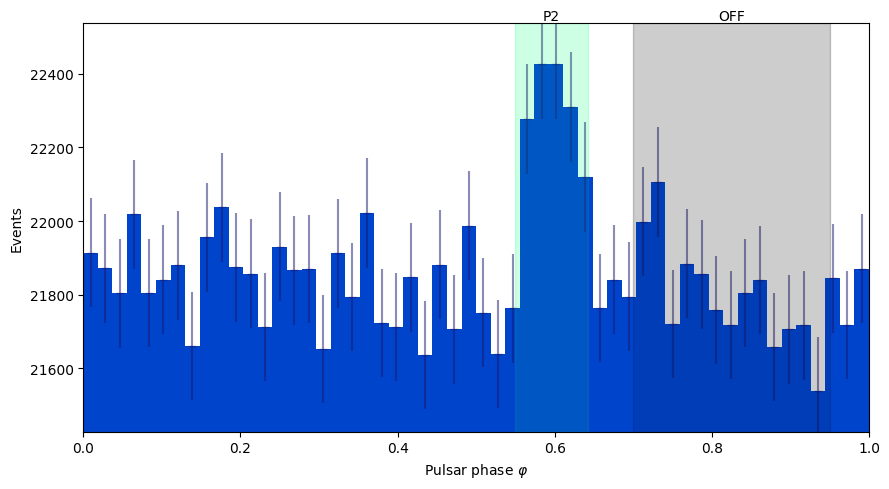

In [4]:
fig,ax = plt.subplots(figsize=(9,5))
hist,edges,_ = ax.hist(phases,range=(0,1),bins=54,color='#0044cc',zorder=0)
centers = (edges[1:]+edges[:-1])/2

#The background is huge and we are well beyond the Poissonian->Gaussian transition.
ax.errorbar(centers,hist,yerr=np.sqrt(hist),fmt='_',color='midnightblue',alpha=0.5,zorder=0)

ax.set_xlim(0,1)
ax.set_ylim(hist.min()-(hist.max()-hist.min())*0.125,hist.max()+(hist.max()-hist.min())*0.125)

OFF = [0.700,0.950]
P2  = [0.550,0.642]
cen = lambda x: np.mean(x)

#Off region
ax.fill_between(OFF,ax.get_ylim()[0],ax.get_ylim()[1],color='k',alpha=0.1,zorder=-1)
ax.fill_between(OFF,ax.get_ylim()[0],ax.get_ylim()[1],color='k',alpha=0.1,zorder=+1)
ax.text(cen(OFF),ax.get_ylim()[1],'OFF',va='bottom',ha='center')


#P2 region
ax.fill_between(P2 ,ax.get_ylim()[0],ax.get_ylim()[1],color='springgreen',alpha=0.1,zorder=-1)
ax.fill_between(P2 ,ax.get_ylim()[0],ax.get_ylim()[1],color='springgreen',alpha=0.1,zorder=+1)
ax.text(cen(P2),ax.get_ylim()[1],'P2',va='bottom',ha='center')

ax.set_xlabel(r"Pulsar phase $\varphi$")
ax.set_ylabel(r"Events")
fig.tight_layout()
plt.show()

There seems to be a large accumulation of events at around phase $\varphi\sim0.6$. This is roughly where the second pulse of Geminga is located at Fermi-LAT energies. But is it significant?

The region of the P2 emission, determined from Fermi-LAT data, is defined by $\varphi \in \text{P2}:=(0.550, 0.642)$. The off region, where no pulsed emission is present, is instead $\text{OFF}:=(0.70,0.95)$. It is important not to play with the region definitions based on the data itself that we are applying them to, otherwise this would, again, introduce a large trial factor.

In [5]:
n_on  = phases[ (phases>=P2[0] ) & (phases<P2[1] ) ].size
n_off = phases[ (phases>=OFF[0]) & (phases<OFF[1]) ].size
alpha = (P2[1]-P2[0])/(OFF[1]-OFF[0])

#Gammapy LiMa
from gammapy.stats import WStatCountsStatistic
wstat = WStatCountsStatistic(n_on,n_off,alpha)
print('P2 significance (gammapy):\t',wstat.sqrt_ts)

#We can also avoid gammapy completely and use the
#actual Li&Ma formula 17. It should be the same.
def CalcLima17(Non,Noff,alfa):
  """
     Calculated LiMa17. If the excess is lower than zero,
     returns a negative significance.
  """
  significance = np.sqrt( 2*Non* np.log( (1+alfa)/alfa * ( Non / (Non+Noff) ) ) + \
                          2*Noff*np.log( (1+alfa)      * ( Noff/ (Non+Noff) ) )   )
  if(Non>alfa*Noff):
    return significance
  else:
    return -significance
print('P2 significance (formula):\t',CalcLima17(n_on,n_off,alpha))

P2 significance (gammapy):	 6.424982595234612
P2 significance (formula):	 6.424982595379388


So we have found a $6.4\,\sigma$ significant signal from Geminga's P2 pulse. We proceed to make its spectrum using gammapy.

# Spectra
As you will see, this is all very standard, and minimally different from any other point-like analysis, for instance that of an AGN. The main difference is importing and using gammapy's class `PhaseBackgroundMaker` to specify the signal and background regions in phase.

In [6]:
import numpy as np
import matplotlib.pyplot as plt

from astropy             import units as u
from astropy.coordinates import SkyCoord

from IPython.display import display

from regions import PointSkyRegion

from gammapy.data            import DataStore
from gammapy.maps            import MapAxis, RegionGeom
from gammapy.datasets        import Datasets, SpectrumDataset
from gammapy.makers          import SpectrumDatasetMaker, PhaseBackgroundMaker
from gammapy.modeling        import Fit
from gammapy.modeling.models import PowerLawSpectralModel, LogParabolaSpectralModel
from gammapy.modeling.models import SkyModel

In [7]:
import warnings
warnings.filterwarnings('ignore')

Here we specify the position of the source and the sizes and binning of the energy axes. This binning is a slight variation of the standard MARS one, with the extremes shifted so that it has a bin beginning at the reconstructed energy of $25\,\text{GeV}$, the minimum meaningful one that was found by folding a spectrum similar to the one of Geminga with the IRFs.

These data also employed Geminga-tailored Monte-Carlo simulations to determine the IRFs and train the RF for the gamma-hadron separation, direction and energy classification. These are MCs with a larger statistics at the lowest energies, that track the path of Geminga in the sky as seen from La Palma. This is similar to the declination bands of LST-1 MCs. Since the target of these observations was the pulsar, the maximum simulated energy of these MCs is $5\,\text{TeV}$. As a result, nothing with an energy greater than few $\text{TeV}$ can be reconstructed meaningfully from this data.

In [8]:
# Geminga
target_position = SkyCoord(ra=98.475638, dec=17.770253, unit="deg", frame="icrs")
on_region       = PointSkyRegion(target_position)

ereco = np.geomspace(5.928434264136119*u.GeV,2.5*u.TeV,21+1)
etrue = np.geomspace(5.928434264136119*u.GeV,2.5*u.TeV,int(21/1.4 + 1))

energy_axis      = MapAxis.from_energy_edges(ereco,name="energy",unit='GeV')
energy_axis_true = MapAxis.from_energy_edges(etrue,name='energy_true',unit='GeV')

## Data Reduction

Loading the data from the indices in the directory.

In [9]:
data_store   = DataStore.from_dir("data/Geminga")
observations = data_store.get_observations(required_irf="point-like")
print(data_store)

Data store:
HDU index table:
BASE_DIR: data/Geminga
Rows: 1350
OBS_ID: 5059985 -- 5080559
HDU_TYPE: [np.str_('aeff'), np.str_('edisp'), np.str_('events'), np.str_('gti'), np.str_('rad_max')]
HDU_CLASS: [np.str_('aeff_2d'), np.str_('edisp_2d'), np.str_('events'), np.str_('gti'), np.str_('rad_max_2d')]


Observation table:
Observatory name: 'N/A'
Number of observations: 270



### Effective time, figure of merit
We can compute the total effective time, to have an idea of how much it is.

In [10]:
t_eff = 0
for i in range(len(observations)):
    t_eff += observations[i].observation_live_time_duration
print('Effective time :', t_eff, ' or ', t_eff.to(u.h))

Effective time : 286307.3734489342 s  or  79.52982595803726 h


So the figure of merit (how much significance we accumulate in time is):

In [11]:
print('Figure of merit:', wstat.sqrt_ts / np.sqrt(t_eff.to(u.h)))
print('TS time:       :', t_eff.to(u.h) / wstat.ts )

Figure of merit: 0.720455132342138 1 / h(1/2)
TS time:       : 1.926575889743219 h


It takes 2 hours to accumulate one unit of TS (variance). Therefore we expect that for a proposal aiming to get $10\,\sigma$ we would need $200\,\text{h}$ of observation time.

### Phased data
Here we create the phase intervals corresponding to the signal and the background, use the `PhaseBackgroundMaker` class to generate the background model, and load the actual observations. From here on everything that follows is a normal, point-like gammapy analysis.

In [12]:
geom = RegionGeom.create(region=on_region, axes=[energy_axis])

dataset_empty = SpectrumDataset.create(geom=geom, energy_axis_true = energy_axis_true)
dataset_maker = SpectrumDatasetMaker(containment_correction=False, selection=["counts", "exposure", "edisp"])

# P2 pulse of Geminga
on_phase  = (0.550, 0.642)
off_phase = (0.700, 0.950)

#I gave the phase column the name "PULSE_PHASE" for consistency with Fermi-LAT fits files.
bkg_maker_phase = PhaseBackgroundMaker(on_phase, off_phase, phase_column_name='PULSE_PHASE')

datasets00 = Datasets()
for observation in observations:
    dataset = dataset_maker.run( dataset_empty.copy(name=str(observation.obs_id)), observation )
    dataset_on_off = bkg_maker_phase.run(dataset, observation)
    datasets00.append(dataset_on_off)

'THETA' axis is stored as a scalar -- converting to 1D array.
'THETA' axis is stored as a scalar -- converting to 1D array.
'THETA' axis is stored as a scalar -- converting to 1D array.
'THETA' axis is stored as a scalar -- converting to 1D array.
'THETA' axis is stored as a scalar -- converting to 1D array.
'THETA' axis is stored as a scalar -- converting to 1D array.
'THETA' axis is stored as a scalar -- converting to 1D array.
The meta information will be empty here.
The meta information will be empty here.
'THETA' axis is stored as a scalar -- converting to 1D array.
'THETA' axis is stored as a scalar -- converting to 1D array.
'THETA' axis is stored as a scalar -- converting to 1D array.
'THETA' axis is stored as a scalar -- converting to 1D array.
'THETA' axis is stored as a scalar -- converting to 1D array.
'THETA' axis is stored as a scalar -- converting to 1D array.
'THETA' axis is stored as a scalar -- converting to 1D array.
The meta information will be empty here.
The meta 

## Sanity checks
We can have a quick look into the IRFs of the data to see if everything looks sane.

### IRFs

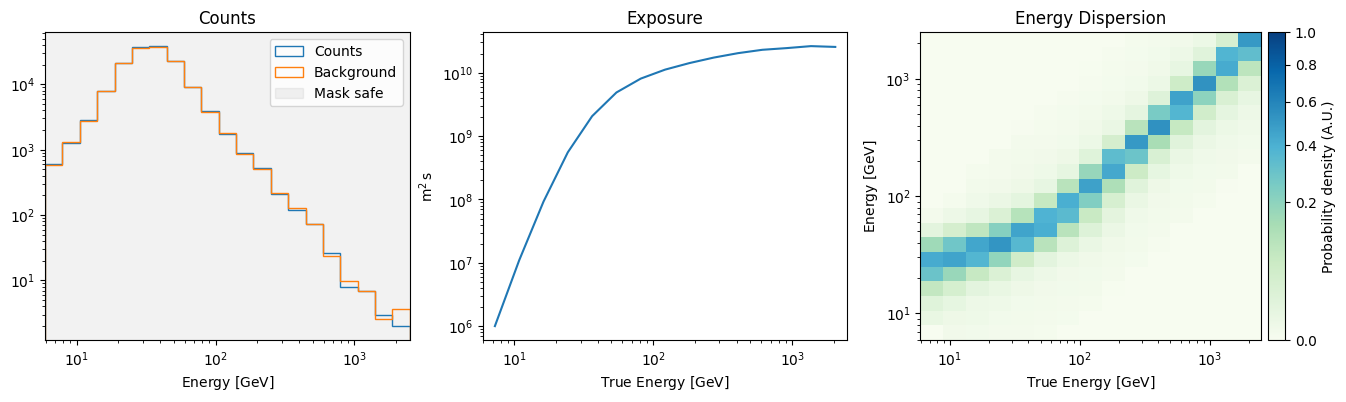

In [13]:
dataset_stacked = datasets00.stack_reduce()
dataset_stacked.peek()

### Energy Dispersion
A closer look to the energy dispersion matrix, here rotated to match the MAGIC/MARS convention (estimated energy on the x axis).

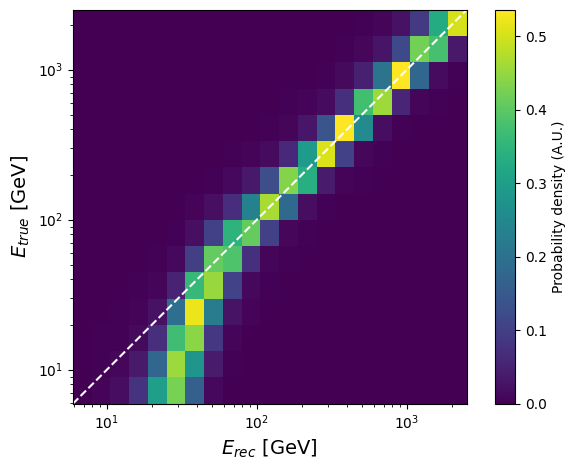

In [14]:
fig, ax = plt.subplots()

kernel = dataset_stacked.edisp.get_edisp_kernel()

data = kernel.data

energy_axis_true = kernel.axes['energy_true']
energy_axis      = kernel.axes['energy']

caxes = ax.pcolormesh(energy_axis.edges, energy_axis_true.edges, data, 
                      cmap='viridis', 
                     )

cbar = plt.colorbar(caxes, ax=ax)
cbar.set_label("Probability density (A.U.)")

ax.set_xlabel("$E_{rec}$ [GeV]", fontsize=14)
ax.set_ylabel("$E_{true}$ [GeV]", fontsize=14)

# Plot the line (y = x)
emin = 5.92
emax = 2.5e3
ax.plot([emin, emax], [emin, emax], color='white', linestyle='--')

ax.set_xlim([emin, emax])
ax.set_ylim([emin, emax])
ax.set_aspect('equal', adjustable='box')

ax.loglog()
fig.tight_layout()
plt.show()

Multiplying this migration matrix with an assumed spectrum similar to the one of Geminga (index -5.2 from the joint fit of MAGIC and Fermi) and the exposure gives us a plot that shows where the excess counts in each reconstructed energy bin really come from and where they're concentracted. It is from such a plot that we can determine the optimal energy interval from the phaseogram, that earlier was set to $25\,\text{GeV}$ to $100\,\text{GeV}$.

In [15]:
#Assumed spectrum
etrue_center = (energy_axis_true.edges[1:] * energy_axis_true.edges[:-1])**0.5
ereco_center = (energy_axis.edges[1:]*energy_axis.edges[:-1])**0.5
assumed_spec = lambda x : (x/(1.*u.GeV))**(-5.2 +1)  #+1 for the logarithmic binning
weights = assumed_spec(etrue_center)
#Pulling the exposure vector out of its shell
weights = weights * dataset_stacked.exposure._data.flatten()
#Renormalizing
weights = weights/weights.sum()

#Matrix multiplication to form a well-shaped
#weight matrix.
weights = np.expand_dims(weights, axis=1)  # len(etrue)×1
onesvec = np.ones((1,data.shape[1]))       # 1×len(ereco)
weight_matrix = weights @ onesvec

data = data*weight_matrix

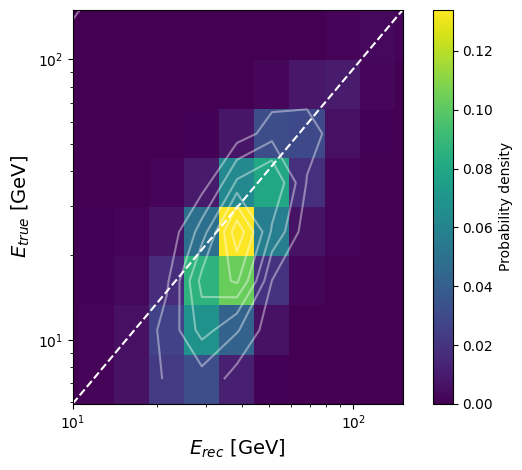

In [16]:
fig, ax = plt.subplots()

caxes = ax.pcolormesh(energy_axis.edges, energy_axis_true.edges, data, cmap='viridis')
conts = ax.contour(ereco_center.value, etrue_center.value, data.value, colors='w', alpha=0.4142)

cbar = plt.colorbar(caxes, ax=ax)
cbar.set_label("Probability density")

ax.set_xlabel("$E_{rec}$ [GeV]", fontsize=14)
ax.set_ylabel("$E_{true}$ [GeV]", fontsize=14)

# Plot the line (y = x)
ermin = 10.
ermax = 150.
etmin = 5.92
etmax = 150.
ax.plot([ermin, ermax], [etmin, etmax], color='white', linestyle='--')

ax.set_xlim([ermin, ermax])
ax.set_ylim([etmin, etmax])
ax.set_aspect('equal', adjustable='box')

ax.loglog()
fig.tight_layout()
plt.show()

Therefore, we expect most of the excess from the pulsar to be at around $E_{\text{reco}}\sim40\,\text{GeV}$, but the majority of those same events actually have real energies below $E_{\text{true}}\leq30\,\text{GeV}$. The lowest energy events at around $E_{\text{reco}}\sim25\,\text{GeV}$ map to events at $E_{\text{true}}\geq10\,\text{GeV}$, corresponding to a bias of 100%. A plot such at the one above can be used to "unfold" a reconstructed energy interval, for example to attribute the correct energy range to the phaseogram. We can also project the plot onto the $E_{\text{true}}$ axis to get the analysis threshold.

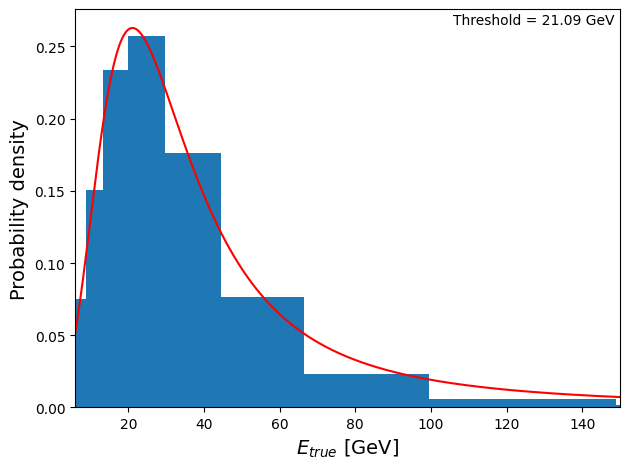

In [17]:
from scipy.optimize import curve_fit
from scipy.stats import landau
land = lambda x,A,mu,c : A*landau.pdf(x,loc=mu+2*c/np.pi*np.log(c),scale=c)

popt,pcov = curve_fit(land,etrue_center,data.sum(axis=1))

fig, ax = plt.subplots()
myx=np.linspace(etmin,etmax,10000)
ax.plot(myx,land(myx,*popt),'r-')

etrue_low  = energy_axis_true.edges[:-1]
etrue_span = energy_axis_true.edges[1:]-energy_axis_true.edges[:-1]
ax.bar(etrue_low,data.sum(axis=1),align='edge',width=etrue_span,color='C0')

threshold = myx[np.argmax(land(myx,*popt))]

ax.text(0.99,0.99,r'Threshold = %0.2f GeV'%threshold,va='top',ha='right',transform=ax.transAxes)

ax.set_ylabel("Probability density", fontsize=14)
ax.set_xlabel("$E_{true}$ [GeV]", fontsize=14)

ax.set_xlim([etmin, etmax])

fig.tight_layout()
plt.show()

Therefore, the energy threshold for this analysis is around $\sim20\,\text{GeV}$.

### Exposure
And we can also have a look directly at the effective area curve. The Sum-Trigger here helps a lot at the lowest energies, allowing to detect the faint signal of Geminga below $\sim80\,\text{GeV}$, which would be impossible to see otherwise.

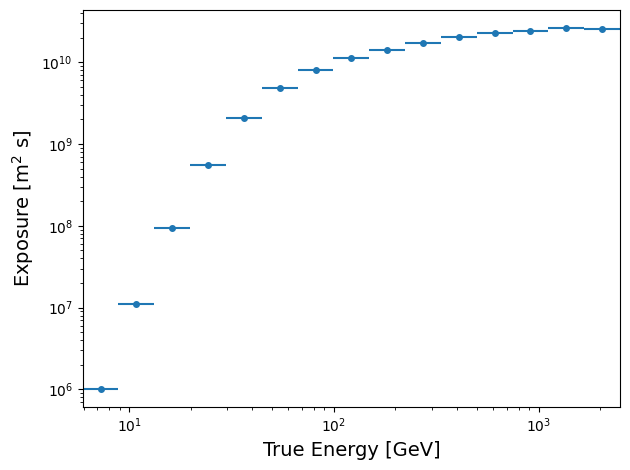

In [18]:
fig, ax = plt.subplots()
dataset_stacked.exposure.plot()
ax.set_xlabel("True Energy [GeV]", fontsize=14)
ax.set_ylabel("Exposure [$\mathrm{m^2\ s}$]", fontsize=14)
fig.tight_layout()
plt.show()

### Counts
Finally, we can peek into the count histograms as well.

In [19]:
mask = dataset_stacked.mask
print("Total signal     counts:", dataset_stacked.counts.data[mask].sum(), " without mask: ", dataset_stacked.counts.data.sum())
print("Total background counts:", dataset_stacked.background.data[mask].sum())

summed_stat = dataset_stacked._counts_statistic[mask].sum()
print("Total excess     counts:", summed_stat.n_sig)

print("Signal to noise ratio  :", summed_stat.n_sig/dataset_stacked.background.data[mask].sum() )


Total signal     counts: 148291.0  without mask:  148291.0
Total background counts: 145758.48
Total excess     counts: 2532.5156
Signal to noise ratio  : 0.017374739


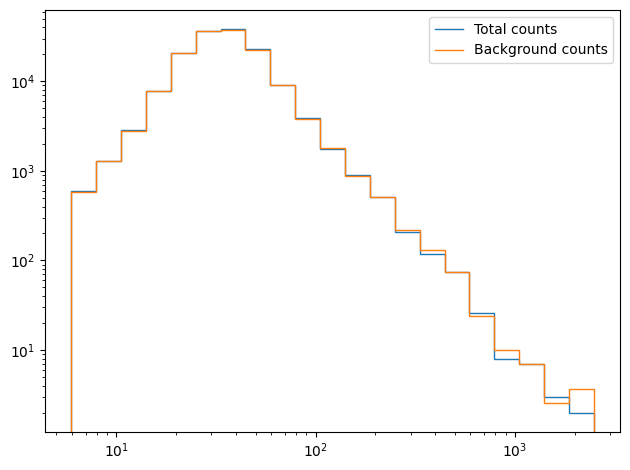

In [20]:
fig, ax = plt.subplots()
bin_edges = dataset_stacked.counts.geom.axes['energy'].edges
ax.stairs(dataset_stacked.counts.data[:,0,0], bin_edges.value, label='Total counts')
ax.stairs(dataset_stacked.background.data[:,0,0], bin_edges.value, label='Background counts')

ax.set_yscale("log")
ax.set_xscale("log")
ax.legend()
fig.tight_layout()
plt.show()

The excesses are very little compared to the background, at the level of 2%. Normally this would be an issue, as the background uncertainty constitutes a systematic that can easily create a fake $\geq5\,\sigma$ significance if the signal to noise ratio is very low. It is generally required that the signal is at least $5\%$ of the background for it to be trustworthy. However, pulsars constitute an exception to this rule, because the background is determined in phase and is thus simultaneous (down to the pulsar period of $0.237\,\text{s}$) and also from the same area in the camera as the signal. It is, in a certain sense, the best possible background, collected by "turning off" the source while keeping all other variables the same. This allows a reliable estimate of the fluxes even if the signal to noise ratio is small.

We have now a closer look to the previous plot in the excess area.

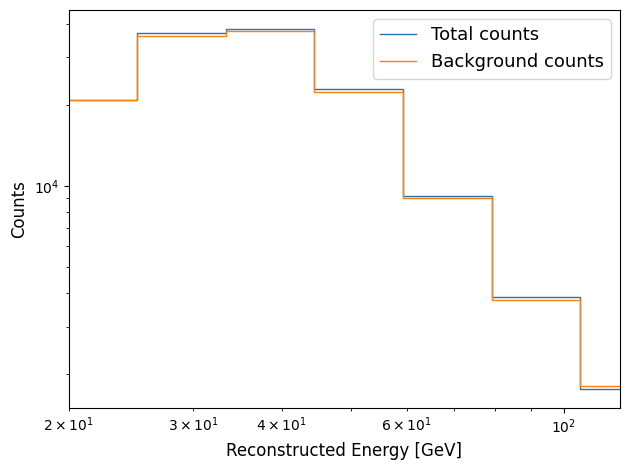

In [21]:
fig, ax = plt.subplots()
bin_edges = dataset_stacked.counts.geom.axes['energy'].edges
ax.stairs(dataset_stacked.counts.data[:,0,0], bin_edges.value, label='Total counts')
ax.stairs(dataset_stacked.background.data[:,0,0], bin_edges.value, label=r'Background counts')

ax.set_yscale("log")
ax.set_xscale("log")
ax.legend( fontsize=13)
ax.set_xlabel("Reconstructed Energy [GeV]", fontsize=12)
ax.set_ylabel("Counts", fontsize=12)
ax.set_xlim(20,120)
ax.set_ylim(1500,45000)
fig.tight_layout()
plt.show()

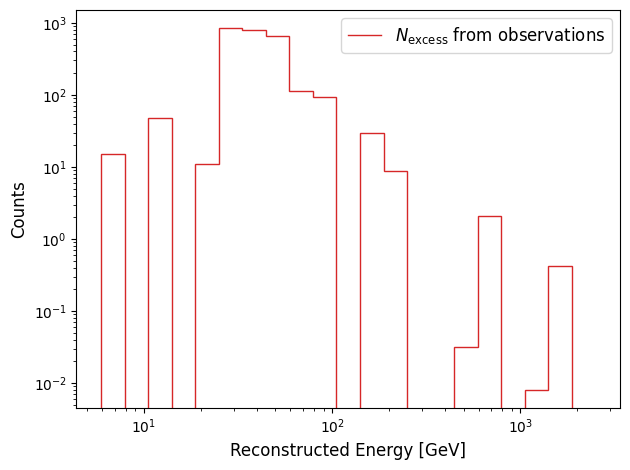

In [22]:
fig, ax = plt.subplots()
bin_edges = dataset_stacked.counts.geom.axes['energy'].edges
ax.stairs(dataset_stacked.excess.data[:,0,0], bin_edges.value, color='C3', label='$N_{\mathrm{excess}}$ from observations')

ax.set_yscale("log")
ax.set_xscale("log")
ax.legend( fontsize=12)
ax.set_xlabel("Reconstructed Energy [GeV]", fontsize=12)
ax.set_ylabel("Counts", fontsize=12)
fig.tight_layout()
plt.show()

As expected, there is no excess whatsoever below $25\,\text{GeV}$ or above $100\,\text{GeV}$ in reconstructed energy.

## Spectrum Fitting
We will fit a power-law and a log-parabola to the data, starting with the stacked likelihood method, and then using the joint one. In both cases, the results are compatible with the MARS ones, and do not show any strong preference for the log-parabola over the power-law.

Strictly speaking, the log-parabola will *always* be favoured over the power-law, because all possible power-laws are also log-parabolas.

### Power-Law (stacked)

In [23]:
dataset_stacked = datasets00.stack_reduce()

spectral_model = PowerLawSpectralModel(
    amplitude=1e-9 * u.Unit("cm-2 s-1 TeV-1"),
    index=5,
    reference=32.15 * u.GeV,
)
model = SkyModel(spectral_model=spectral_model, name="gemingaP2_pwl")
dataset_stacked.models = [model]

fit_pwl=Fit()
result_pwl = fit_pwl.run(datasets=dataset_stacked)
model_pwl_stacked = model.copy()

print(result_pwl)
display(result_pwl.models.to_parameters_table())

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 73
	total stat : 9.29

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.



model,type,name,value,unit,error,min,max,frozen,link,prior
str13,str1,str9,float64,str14,float64,float64,float64,bool,str1,str1
gemingaP2_pwl,,index,5.1673e+00,,4.122e-01,nan,nan,False,,
gemingaP2_pwl,,amplitude,2.6181e-09,TeV-1 s-1 cm-2,6.161e-10,nan,nan,False,,
gemingaP2_pwl,,reference,3.2150e+01,GeV,0.000e+00,nan,nan,True,,


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 9.287                      │              Nfcn = 73               │
│ EDM = 6.15e-07 (Goal: 0.0002)    │            time = 0.1 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬───

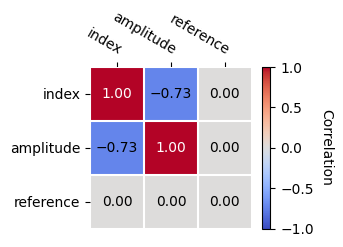

In [24]:
# detailed info
print(result_pwl.minuit)
print()
print('Covariance matrix:\n', result_pwl.models.covariance, '\n')
result_pwl.models.covariance.plot_correlation()
plt.show()

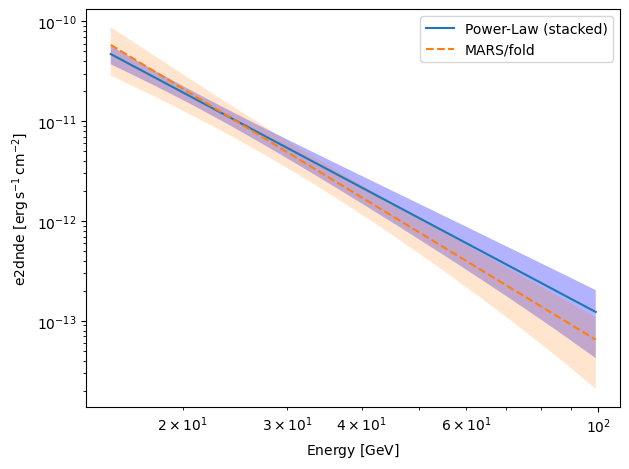

In [25]:
fig, ax = plt.subplots()
plot_kwargs = {
    "energy_bounds": [15, 100] * u.GeV,
    "sed_type": "e2dnde",
    "ax": ax,
}

magic2020_paper=PowerLawSpectralModel(
    amplitude= 2.3e-9*u.Unit("TeV-1 cm-2 s-1"),
    reference= 32.15*u.GeV,
    index = 5.62,
)

#This neglects the correlation between the parameters, but for a simple plot as this one it is OK.
magic2020_paper.parameters['index'].error = 0.54
magic2020_paper.parameters['amplitude'].error = 0.7e-9 * u.Unit("TeV-1 cm-2 s-1")

model_pwl_stacked.spectral_model.plot(**plot_kwargs, label="Power-Law (stacked)")
model_pwl_stacked.spectral_model.plot_error(**plot_kwargs, facecolor="blue", alpha=0.3)
magic2020_paper.plot(**plot_kwargs, ls='--', label="MARS/fold")
magic2020_paper.plot_error(**plot_kwargs, facecolor="C1", ls='--')
ax.legend()
fig.tight_layout()
plt.show()

### Power-Law (joined)

In [26]:
spectral_model = PowerLawSpectralModel(
    amplitude=1e-9 * u.Unit("cm-2 s-1 TeV-1"),
    index=5,
    reference=32.15 * u.GeV,
)
model = SkyModel(spectral_model=spectral_model, name="gemingaP2_pwl")
datasets00.models = [model]

fit_pwl=Fit()
result_pwl = fit_pwl.run(datasets=datasets00)
model_pwl = model.copy()

print(result_pwl)
display(result_pwl.models.to_parameters_table())

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 78
	total stat : 4178.24

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.



model,type,name,value,unit,error,min,max,frozen,link,prior
str13,str1,str9,float64,str14,float64,float64,float64,bool,str1,str1
gemingaP2_pwl,,index,5.1576e+00,,3.789e-01,nan,nan,False,,
gemingaP2_pwl,,amplitude,2.5824e-09,TeV-1 s-1 cm-2,5.878e-10,nan,nan,False,,
gemingaP2_pwl,,reference,3.2150e+01,GeV,0.000e+00,nan,nan,True,,


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 4178                       │              Nfcn = 78               │
│ EDM = 2.69e-06 (Goal: 0.0002)    │           time = 35.2 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬───

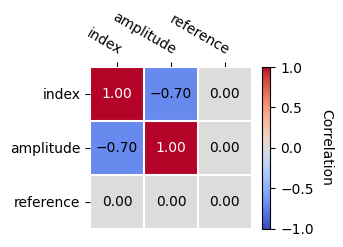

In [27]:
# detailed info
print(result_pwl.minuit)
print()
print('Covariance matrix:\n', result_pwl.models.covariance, '\n')
result_pwl.models.covariance.plot_correlation()
plt.show()

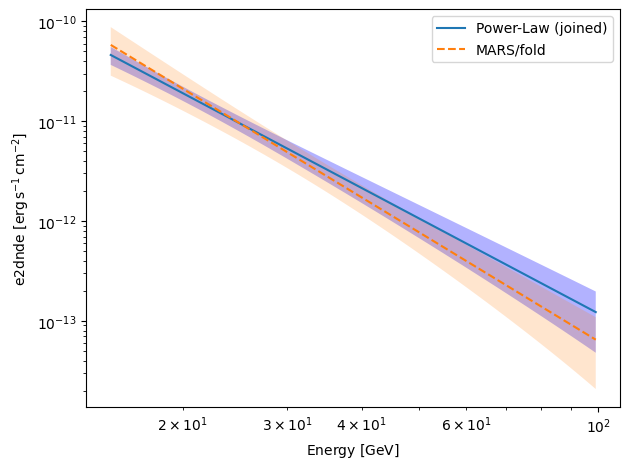

In [28]:
fig, ax = plt.subplots()
plot_kwargs = {
    "energy_bounds": [15, 100] * u.GeV,
    "sed_type": "e2dnde",
    "ax": ax,
}

model_pwl.spectral_model.plot(**plot_kwargs, label="Power-Law (joined)")
model_pwl.spectral_model.plot_error(**plot_kwargs, facecolor="blue", alpha=0.3)
magic2020_paper.plot(**plot_kwargs, ls='--', label="MARS/fold")
magic2020_paper.plot_error(**plot_kwargs, ls='--', facecolor="C1")
plt.legend()
fig.tight_layout()
plt.show()

### Log-Parabola (stacked)

In [29]:
spectral_model = LogParabolaSpectralModel(
    amplitude = 1e-9 * u.Unit("cm-2 s-1 TeV-1"),
    reference = 32.15 * u.Unit("GeV"),
    alpha = 5,
    beta = 1,
)

model = SkyModel(spectral_model = spectral_model, name="logp_joint")
dataset_stacked.models = [model]

fit_parab = Fit()
result_parab = fit_parab.run(datasets=dataset_stacked)

model_parab_stacked = model.copy()
print(result_parab)
display(result_parab.models.to_parameters_table())

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 151
	total stat : 9.10

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.



model,type,name,value,unit,error,min,max,frozen,link,prior
str10,str1,str9,float64,str14,float64,float64,float64,bool,str1,str1
logp_joint,,amplitude,2.8516e-09,TeV-1 s-1 cm-2,9.110e-10,nan,nan,False,,
logp_joint,,reference,3.2150e+01,GeV,0.000e+00,nan,nan,True,,
logp_joint,,alpha,5.3801e+00,,8.518e-01,nan,nan,False,,
logp_joint,,beta,3.7156e-01,,1.063e+00,nan,nan,False,,


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 9.103                      │              Nfcn = 151              │
│ EDM = 1.53e-05 (Goal: 0.0002)    │            time = 0.3 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬───

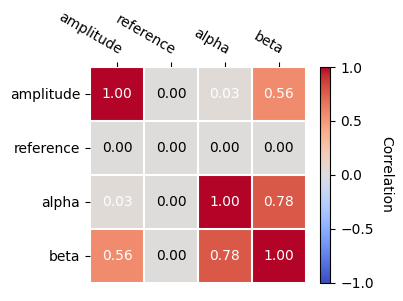

In [30]:
# detailed info
print(result_parab.minuit)
print()
print('Covariance matrix:\n', result_pwl.models.covariance, '\n')
result_parab.models.covariance.plot_correlation()
plt.show()

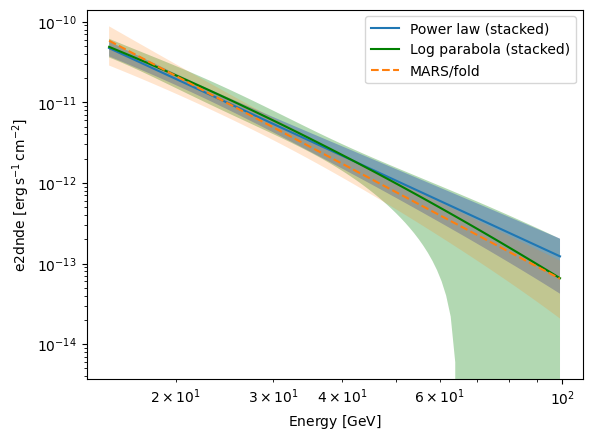

In [31]:
fig, ax = plt.subplots()

plot_kwargs = {
    "energy_bounds": [15, 100] * u.GeV,
    "sed_type": "e2dnde",
    "ax": ax,
}

# plot models
model_pwl_stacked.spectral_model.plot(**plot_kwargs, label="Power law (stacked)")
model_pwl_stacked.spectral_model.plot_error(facecolor="blue", alpha=0.3, **plot_kwargs)

model_parab_stacked.spectral_model.plot(**plot_kwargs, color="green", label="Log parabola (stacked)")
model_parab_stacked.spectral_model.plot_error(facecolor="green", alpha=0.3, **plot_kwargs)

magic2020_paper.plot(**plot_kwargs, ls='--', color="C1", label="MARS/fold")
magic2020_paper.plot_error(**plot_kwargs, ls='--', facecolor="C1")

ax.legend()
plt.show()

### Log-Parabola (joined)

In [32]:
spectral_model = LogParabolaSpectralModel(
    amplitude = 1e-9 * u.Unit("cm-2 s-1 TeV-1"),
    reference = 32.15 * u.Unit("GeV"),
    alpha = 5,
    beta = 0.2,
)

model = SkyModel(spectral_model = spectral_model, name="logp")
datasets00.models = [model]

fit_parab = Fit()
result_parab = fit_parab.run(datasets=datasets00)

model_parab = model.copy()
print(result_parab)
display(result_parab.models.to_parameters_table())

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 125
	total stat : 4177.37

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.



model,type,name,value,unit,error,min,max,frozen,link,prior
str4,str1,str9,float64,str14,float64,float64,float64,bool,str1,str1
logp,,amplitude,3.1139e-09,TeV-1 s-1 cm-2,9.924e-10,nan,nan,False,,
logp,,reference,3.2150e+01,GeV,0.000e+00,nan,nan,True,,
logp,,alpha,5.5009e+00,,9.798e-01,nan,nan,False,,
logp,,beta,7.4766e-01,,1.249e+00,nan,nan,False,,


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 4177                       │              Nfcn = 125              │
│ EDM = 7.42e-08 (Goal: 0.0002)    │           time = 71.7 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬───

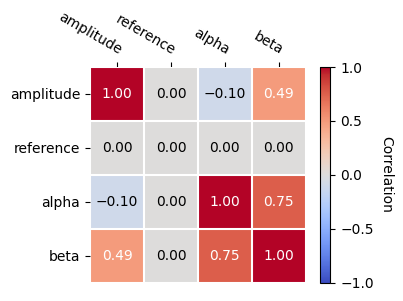

In [33]:
# detailed info
print(result_parab.minuit)
print()
print('Covariance matrix:\n', result_pwl.models.covariance, '\n')
result_parab.models.covariance.plot_correlation()
plt.show()

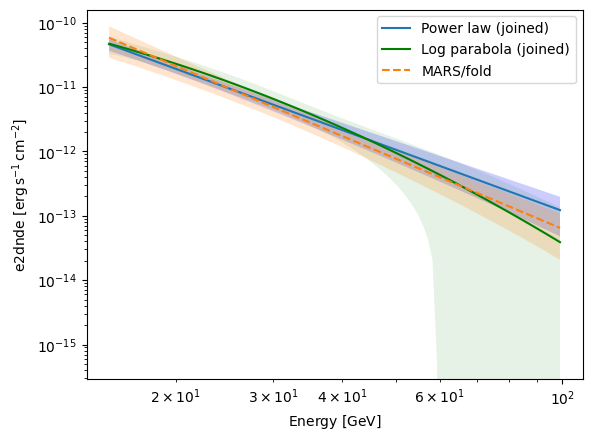

In [34]:
fig, ax = plt.subplots()

plot_kwargs = {
    "energy_bounds": [15, 100] * u.GeV,
    "sed_type": "e2dnde",
    "ax": ax,
}

model_pwl.spectral_model.plot(**plot_kwargs, label="Power law (joined)")
model_pwl.spectral_model.plot_error(**plot_kwargs, facecolor="blue", alpha=0.2)

model_parab.spectral_model.plot(**plot_kwargs, color="green",label="Log parabola (joined)" )
model_parab.spectral_model.plot_error(facecolor="green", alpha=0.1, **plot_kwargs)

magic2020_paper.plot(**plot_kwargs, ls='--', color="C1", label="MARS/fold")
magic2020_paper.plot_error(facecolor="C1", alpha=0.2, **plot_kwargs)

ax.legend()
plt.show()

## Spectral points
Unfortunately, the gammapy spectral points algorithm is unsuitable for very steep spectra with large energy resolution and bias, which is precisely the case for pulsars. This does not stem from a technical limitation (that means: you can run the flux point maker on these data, and you will obtain results), but from an intrinsic inadeguacy of the rationale the procedure is based on.

In gammapy, spectral points are determied by fitting a power-law locally tangent to the global fitted model (optionally the index can be fixed to 2 instead, i.e. a flat constant in SED) on each single bin of the counts vs. **reconstructed** energy histogram. The normalization factor of each of those power-laws is then used to make spectral points, that are attributed a range equal to the estimated energy bin they were created from. These points will be aligned to the reconstructed energy edges.

When the energy bias is very large events in the reconstructed energy bin $20\,\text{GeV}$ to $40\,\text{GeV}$ in reality map to events between $10\,\text{GeV}$ and $30\,\text{GeV}$. The spectral fitting procedure of gammapy obviously accounts for this migration in the IRF, but the spectral point calculator will assign the flux computed from those events to a point (roughly) between $20\,\text{GeV}$ and $40\,\text{GeV}$. This means that altough the data effectively contains events down to $10\,\text{GeV}$, as can be seen by plotting the energy threshold, no spectral point can be produced down there. See for instance the LST-1 Geminga paper here: https://www.aanda.org/articles/aa/full_html/2025/06/aa54350-25/aa54350-25.html .

Different groups have come up with different approaches to this issue. H.E.S.S., for instance, does not publish data-points for its pulsars, but only the spectral fits with the associated uncertainty butterflies.

An alternative approach to produce spectral points within a Bayesian framework and using Markov-chain monte-carlo sampling has been put forward in the master thesis of Yunhe Wang, under my supervision. In such a Bayesian approach, setting a prior on the model "parameters" (the flux of each spectral point is a parameter) is mathematically equivalent to imposing a regularization procedure, as is done in MARS by the infamous CombUnfold program. The interested reader might find information in the thesis of Yunhe Wang: https://www.mpp.mpg.de/~ceribell/YunheWang_thesis_20250214.pdf